Q2. Find top 10 studio with their the revenue ratio every year.

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import sqlite3
from sklearn.preprocessing import OneHotEncoder
from zipfile import ZipFile
import tarfile
import gzip
import matplotlib.pyplot as plt


1. Unzip & import Dataframes

In [2]:
with gzip.open("zippedData/bom.movie_gross.csv.gz", "rb") as f:
    bom_movie_gross = pd.read_csv(f)

with gzip.open("zippedData/tmdb.movies.csv.gz", "rb") as f:
    tmdb_movies = pd.read_csv(f)

with gzip.open("zippedData/tn.movie_budgets.csv.gz", "rb") as f:
    tn_movie_budgets = pd.read_csv(f)


2. Setting Dataframs' index to 'title'

In [3]:
bom_movie_gross.set_index('title', inplace=True)

tn_movie_budgets = tn_movie_budgets.rename(columns={'movie':'title'})
tn_movie_budgets.set_index('title', inplace=True)

tmdb_movies.set_index('title', inplace=True)
tmdb_movies = tmdb_movies.drop(['id', 'Unnamed: 0', 'original_language', 'original_title', 'genre_ids'], axis=1)

3. Join Dataframes

In [4]:
movie_budget = tn_movie_budgets.join(bom_movie_gross, how='outer', rsuffix='_bom')
movie_budget_pop = movie_budget.join(tmdb_movies, how='outer', rsuffix='_pop')

4. Data cleaning

In [5]:
# remove dollar sign
movie_budget_pop.domestic_gross[movie_budget_pop.domestic_gross.str[0] == "$"] = movie_budget_pop.domestic_gross.str[1:]
movie_budget_pop.production_budget[movie_budget_pop.production_budget.str[0] == "$"] = movie_budget_pop.production_budget.str[1:]
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross.str[0] == "$"] = movie_budget_pop.worldwide_gross.str[1:]


# remove ',' sign
movie_budget_pop['production_budget'] = movie_budget_pop['production_budget'].str.replace(',','', regex=True)
movie_budget_pop['domestic_gross'] = movie_budget_pop['domestic_gross'].str.replace(',','', regex=True)
movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].str.replace(',','', regex=True)
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].str.replace(',','', regex=True)


# rename studio column values
movie_budget_pop['studio'] = movie_budget_pop['studio'].str.replace('FoxS','Fox', regex=True)
movie_budget_pop['studio'] = movie_budget_pop['studio'].str.replace("WB (NL)","WB", regex=False)


# change 'domestic_gross_bom' type to str
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].astype('str')


# remove .00 from year
movie_budget_pop['year'] = movie_budget_pop['year'].astype('str')
movie_budget_pop.domestic_gross_bom = movie_budget_pop.domestic_gross_bom.str[0:-2]
movie_budget_pop.year = movie_budget_pop.year.str[0:-2]


# fill NaN values
movie_budget_pop['domestic_gross'] = movie_budget_pop['domestic_gross'].fillna(movie_budget_pop['domestic_gross_bom'])
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].fillna(0)
movie_budget_pop.domestic_gross_bom[movie_budget_pop.domestic_gross_bom == "n"] = 0

movie_budget_pop.foreign_gross[movie_budget_pop.foreign_gross.str[-2] == "."] = movie_budget_pop.foreign_gross.str[0:-2]
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].fillna(0)
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].astype('int')
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].astype('int')
movie_budget_pop['new_total'] = movie_budget_pop['domestic_gross_bom'] + movie_budget_pop['foreign_gross']

movie_budget_pop.new_total[movie_budget_pop.new_total == 0] = np.nan
movie_budget_pop['new_total'] = movie_budget_pop['new_total'].astype('str')

movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].fillna(movie_budget_pop['new_total'])
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross.str[-2] == "."] = movie_budget_pop.worldwide_gross.str[0:-2]
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross == '0'] = np.nan
movie_budget_pop.dropna(subset=['production_budget', 'worldwide_gross'], inplace=True)

movie_budget_pop.year[movie_budget_pop.year == "n"] = np.nan
movie_budget_pop['rel_year'] = movie_budget_pop['release_date'].str[-4:]
movie_budget_pop['rel_year2'] = movie_budget_pop['release_date_pop'].str[:4]

movie_budget_pop['year'] = movie_budget_pop['year'].fillna(movie_budget_pop['rel_year'])
movie_budget_pop['year'] = movie_budget_pop['year'].fillna(movie_budget_pop['rel_year2'])



# drop values
movie_budget_pop = movie_budget_pop.drop(['domestic_gross_bom', 'foreign_gross', 'new_total', 'rel_year', 'release_date', 'id', 'domestic_gross', 'release_date_pop', 'rel_year2'], axis=1)


<ipython-input-5-e32789863c6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.domestic_gross[movie_budget_pop.domestic_gross.str[0] == "$"] = movie_budget_pop.domestic_gross.str[1:]
<ipython-input-5-e32789863c6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.production_budget[movie_budget_pop.production_budget.str[0] == "$"] = movie_budget_pop.production_budget.str[1:]
<ipython-input-5-e32789863c6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [9]:
movie_budget_pop.sort_values('worldwide_gross', ascending=False)

,production_budget,worldwide_gross,studio,year,popularity,vote_average,vote_count,profit_budget_ratio
title,,,,,,,,
Avatar,425000000,2.776345e+09,NaN,2009,26.526,7.4,18676.0,6.532577
Titanic,200000000,2.208208e+09,NaN,1997,NaN,NaN,NaN,11.041042
Star Wars Ep. VII: The Force Awakens,306000000,2.053311e+09,NaN,2015,NaN,NaN,NaN,6.710167
Avengers: Infinity War,300000000,2.048134e+09,BV,2018,80.773,8.3,13948.0,6.827114
Jurassic World,215000000,1.648855e+09,Uni.,2015,20.709,6.6,14056.0,7.669092
...,...,...,...,...,...,...,...,...
Destiny,750000,4.500000e+02,NaN,2014,NaN,NaN,NaN,0.000600
The Dark Hours,400000,4.230000e+02,NaN,2005,NaN,NaN,NaN,0.001058
The Rise and Fall of Miss Thang,10000,4.010000e+02,NaN,2008,NaN,NaN,NaN,0.040100


In [6]:
# add 'profit_budget_ratio' columns

movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].astype('float')
movie_budget_pop['production_budget'] = movie_budget_pop['production_budget'].astype('int')
movie_budget_pop['profit_budget_ratio'] = movie_budget_pop['worldwide_gross'] / movie_budget_pop['production_budget']


5. Check the relationship between('worldwide_gross', 'production_budget')

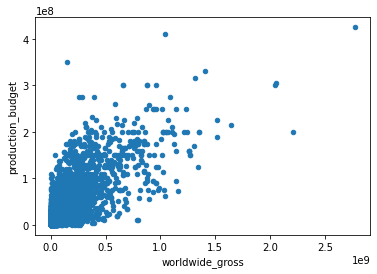

In [76]:
movie_budget_pop.plot.scatter('worldwide_gross', 'production_budget');

6. make new dataframe without 'studio' NaN values

In [77]:
# drop 'studio' NaN values' rows 
new_set = movie_budget_pop.dropna(subset=['studio'])
new_set = new_set.drop(['vote_count', 'vote_average', 'popularity'], axis=1)
new_set = new_set.drop_duplicates()


In [78]:
# make year_count dataframe by using groupby
year_count = new_set.groupby(['year'], sort=True)['production_budget'].count()
year_sum = new_set.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()

<ipython-input-78-28f250344ca0>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year_sum = new_set.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()


7. Check total production budget, worldwide gross, total number of movies

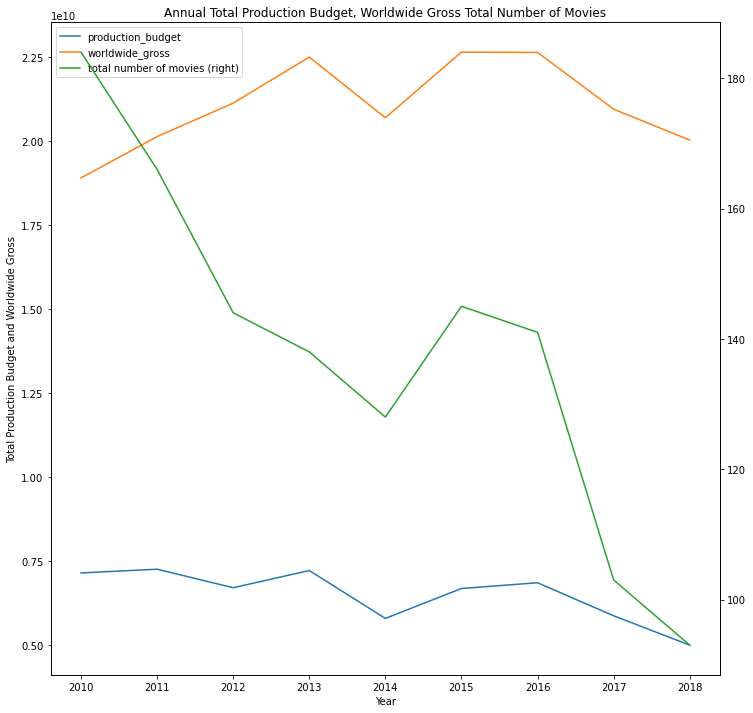

In [79]:
ax = year_sum.plot(figsize=(12,12))

year_count.plot(secondary_y=True, ax=ax, label='total number of movies', legend=True)



ax.set_title('Annual Total Production Budget, Worldwide Gross Total Number of Movies')
ax.set_xlabel('Year')
ax.set_ylabel('Total Production Budget and Worldwide Gross');

8. make dataframe which explain studio's annual data

In [80]:
year_studio_sum = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget', 'worldwide_gross'].sum()
year_studio_count = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget'].count()
year_studio_sum['count'] = year_studio_count
year_studio_sum = year_studio_sum.reset_index()


<ipython-input-80-37c81b05818e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year_studio_sum = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget', 'worldwide_gross'].sum()


In [81]:
# find top 30 worldwide gross of year_studio_sum's studio name
top30_year_studio_sum = year_studio_sum.nlargest(30, ['worldwide_gross'])
list_top30_year_studio_sum = list(set(top30_year_studio_sum['studio']))
print(list_top30_year_studio_sum)

['Fox', 'Par.', 'WB', 'Sony', 'Uni.', 'BV']


9. drow plots of top 30 worldwide gross of year_studio_sum's studio data

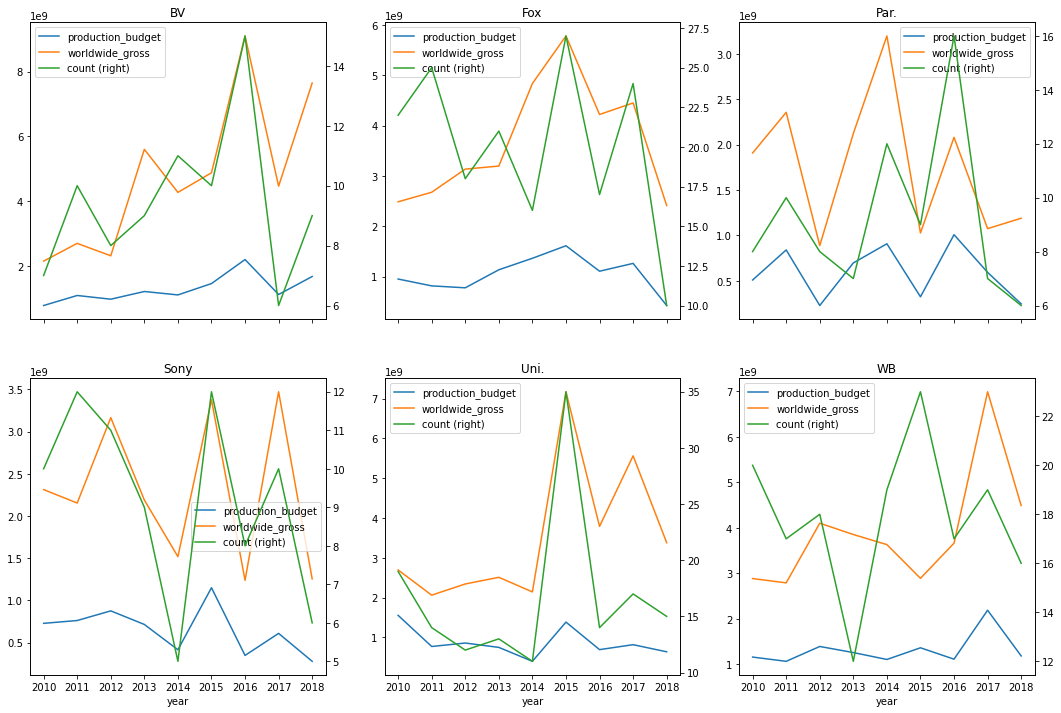

In [82]:
year_studio_sum = year_studio_sum.set_index('year')

fig, axes = plt.subplots(2,3, figsize=(18,12))
fig.title = ['Top 6 Studio Budget, Profit, Number of Movies']
year_studio_sum[year_studio_sum['studio']=='BV'].plot(ax=axes[0,0], secondary_y=['count'])
axes[0, 0].set_title('BV')
year_studio_sum[year_studio_sum['studio']=='Fox'].plot(ax=axes[0,1], secondary_y=['count'])
axes[0, 1].set_title('Fox')
year_studio_sum[year_studio_sum['studio']=='Par.'].plot(ax=axes[0,2], secondary_y=['count'])
axes[0, 2].set_title('Par.')
year_studio_sum[year_studio_sum['studio']=='Sony'].plot(ax=axes[1,0], secondary_y=['count'])
axes[1, 0].set_title('Sony')
year_studio_sum[year_studio_sum['studio']=='Uni.'].plot(ax=axes[1,1], secondary_y=['count'])
axes[1, 1].set_title('Uni.')
year_studio_sum[year_studio_sum['studio']=='WB'].plot(ax=axes[1,2], secondary_y=['count'])
axes[1, 2].set_title('WB');


10. average values of major 6 studios's, period: 9years

In [83]:
year_studio_sum[year_studio_sum['studio'].isin(list_top30_year_studio_sum)].mean().astype(str)

production_budget    962762592.5925926
worldwide_gross      3329389576.703704
count                13.74074074074074
dtype: object